## **Predicting hERG Blocker**  

### **Import Statements**  

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import pickle as pkl

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Draw
from collections import Counter

from tdc.single_pred import Tox

from scripts.load_dataset import DataDownloader
from scripts.clean_transform_data import DataProcessor
from scripts.exploratory_analysis import ExploratoryDataAnalysis
from scripts.train_evaluate_model import DatasetProcessor, Modelling
from scripts.feature_engineering import Featurizer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### **Getting to Know Our Data**  

In [2]:
dataset_name = "hERG"
downloader = DataDownloader()
df, splits = None, None

In [3]:
use_existing_data = 'Y'

In [4]:
if use_existing_data == 'N':
    print("\nDownloading data...")
    df, splits = downloader.fetch_dataset(name = dataset_name)
else:
    print("\nLoading existing data...")
    try:
        df = pd.read_csv(f'../data/{dataset_name}.csv')
        train = pd.read_csv(f'../data/train.csv') 
        validation = pd.read_csv(f'../data/validation.csv') 
        test = pd.read_csv(f'../data/test.csv')
        splits = {"train": train, "validation": validation, "test": test}
        print("Data successfully loaded.")
    except FileNotFoundError as e:
        print(f"Error: {e}. Dataset not found, attempting to download...")
        df, splits = downloader.fetch_dataset(name = dataset_name)


Loading existing data...
Data successfully loaded.


In [5]:
splits.keys()

dict_keys(['train', 'validation', 'test'])

In [6]:
split_files = [f"../data/{key}.csv" for key in splits.keys()] #train, test and split
split_files

['../data/train.csv', '../data/validation.csv', '../data/test.csv']

In [7]:
for file in split_files:
    processor = DataProcessor(input_csv = file, output_csv = file)
    processor.process_csv()

2025-04-03 12:15:20,547 - INFO - No missing Drug_IDs found. No processing needed.
2025-04-03 12:15:20,563 - INFO - No missing Drug_IDs found. No processing needed.
2025-04-03 12:15:20,571 - INFO - No missing Drug_IDs found. No processing needed.


In [8]:
train.head()

,Drug_ID,Drug,Y
0,DELAVIRDINE,CC(C)Nc1cccnc1N1CCN(C(=O)C2=CC3=C[C@H](NS(C)(=...,0.00
1,SOPHOCARPINE,O=C1C=CC[C@@H]2[C@H]3CCCN4CCC[C@H](CN12)[C@H]34,0.00
2,RALOXIFENE,O=C(c1ccc(OCC[NH+]2CCCCC2)cc1)c1c(-c2ccc(O)cc2...,0.00
3,N-DEMETHYLOLANZAPINE,Cc1cc2c(s1)Nc1ccccc1N=C2N1CCNCC1,1.00
4,SUNITINIB,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...,1.00


### **Brief EDA** 

2025-04-03 12:15:20,633 - INFO - Absolute data path: /home/gentroyal/outreachy-temp/data/hERG.csv
2025-04-03 12:15:20,633 - INFO - Absolute data path: /home/gentroyal/outreachy-temp/data/hERG.csv
2025-04-03 12:15:20,639 - INFO - Absolute figure directory: /home/gentroyal/outreachy-temp/data/figures
2025-04-03 12:15:20,639 - INFO - Absolute figure directory: /home/gentroyal/outreachy-temp/data/figures
2025-04-03 12:15:20,649 - INFO - Figure directory verified at: /home/gentroyal/outreachy-temp/data/figures
2025-04-03 12:15:20,649 - INFO - Figure directory verified at: /home/gentroyal/outreachy-temp/data/figures
2025-04-03 12:15:20,655 - INFO - 451 drugs are classified as blockers
2025-04-03 12:15:20,655 - INFO - 451 drugs are classified as blockers
2025-04-03 12:15:20,657 - INFO - 204 drugs are classified as non-blockers
2025-04-03 12:15:20,657 - INFO - 204 drugs are classified as non-blockers
2025-04-03 12:15:20,724 - INFO - Using categorical units to plot a list of strings that are al

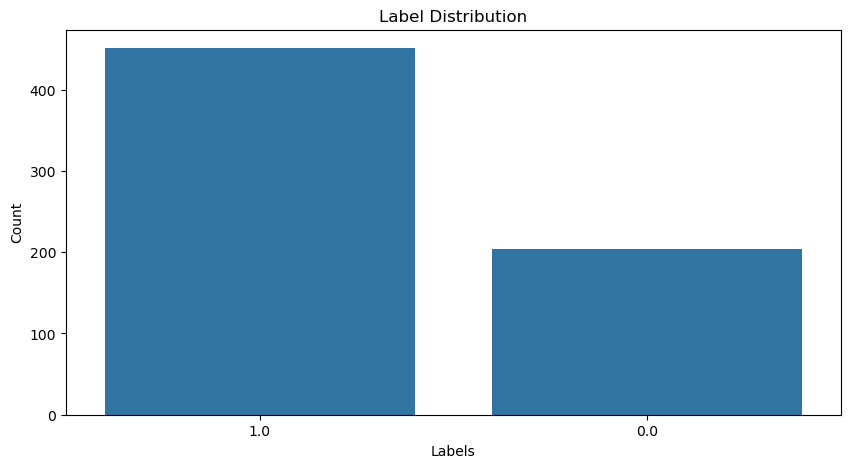

2025-04-03 12:15:21,286 - INFO - Saved figure to: /home/gentroyal/outreachy-temp/data/figures/label_distribution.png
2025-04-03 12:15:21,286 - INFO - Saved figure to: /home/gentroyal/outreachy-temp/data/figures/label_distribution.png


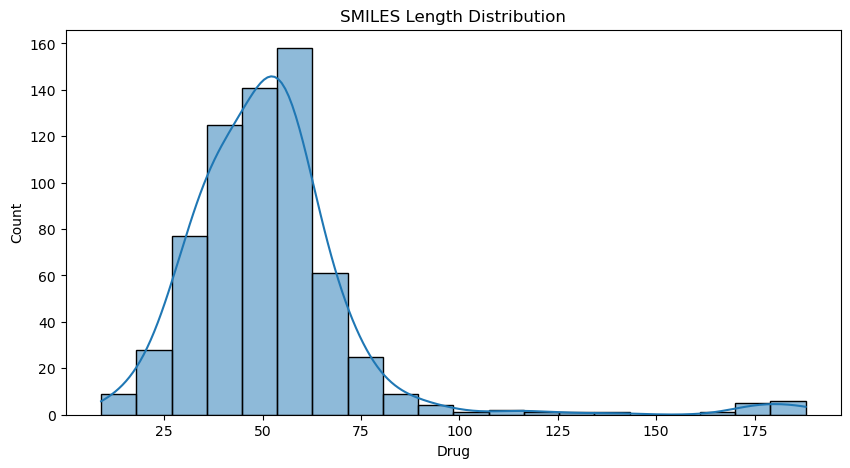

2025-04-03 12:15:22,406 - INFO - Saved figure to: /home/gentroyal/outreachy-temp/data/figures/smiles_length.png
2025-04-03 12:15:22,406 - INFO - Saved figure to: /home/gentroyal/outreachy-temp/data/figures/smiles_length.png
2025-04-03 12:15:22,410 - INFO - EDA for hERG completed successfully.
2025-04-03 12:15:22,410 - INFO - EDA for hERG completed successfully.


In [9]:
explore = ExploratoryDataAnalysis(dataset_name)
explore.generate_eda()

**Comment:** There are 451 blockers (classed as 1) and and 204 nonblockers (classed as 0). Since there is a huge difference in the number of samples in both classes, it means that there is an imbalance and we need to address this before we can train our machine learning model.

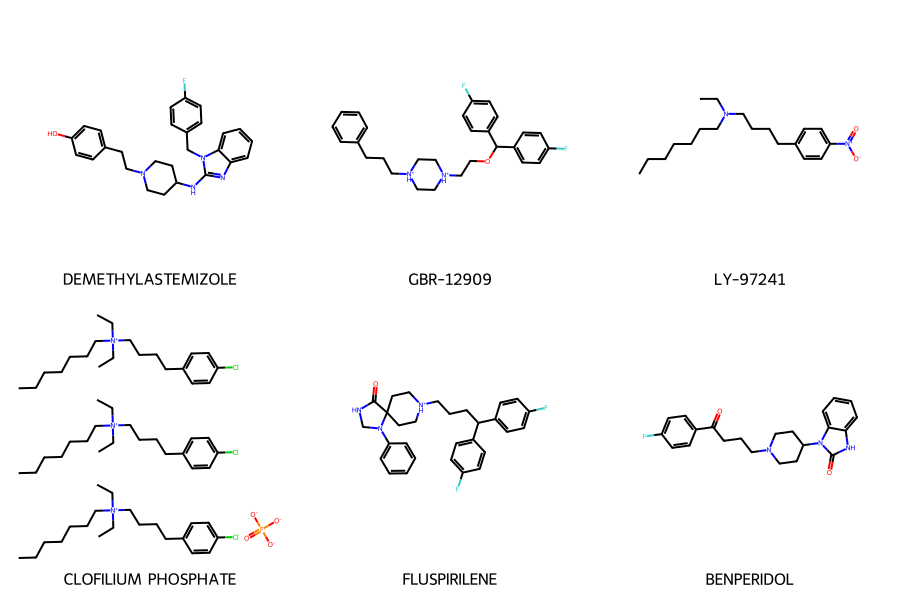

In [10]:
smiles_list = df["Drug"].iloc[:6].tolist()  # First 6 SMILES
drug_names = df["Drug_ID"].iloc[:6].tolist()  # Their Names

mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
Draw.MolsToGridImage(mols, molsPerRow = 3, subImgSize=(300, 300), legends=drug_names)

### **Featurizer**  

In [16]:
featuriser = "eos5guo" # eos2gw4" 
!ersilia fetch $featuriser

⬇️  Fetching model eos5guo: erg-descs
👎 Model eos5guo failed to fetch! Model already exists on your system. If you want to fetch it again, please delete the existing model first.


In [17]:
files = ['train', 'test', 'validation']

featurizer = Featurizer(model_id = featuriser)
for file in files:
    output_path = featurizer.featurize_csv(input_file = file)

2025-04-04 18:13:19,362 - INFO - Loading Ersilia model: eos5guo
2025-04-04 18:13:19,362 - INFO - Loading Ersilia model: eos5guo
2025-04-04 18:13:36,468 - INFO - Model served successfully
2025-04-04 18:13:36,468 - INFO - Model served successfully
2025-04-04 18:13:40,135 - INFO - Featurization completed in 20.77s for ../data/train.csv
2025-04-04 18:13:40,135 - INFO - Featurization completed in 20.77s for ../data/train.csv
2025-04-04 18:13:40,139 - INFO - Loading Ersilia model: eos5guo
2025-04-04 18:13:40,139 - INFO - Loading Ersilia model: eos5guo
2025-04-04 18:13:58,190 - INFO - Model served successfully
2025-04-04 18:13:58,190 - INFO - Model served successfully
2025-04-04 18:13:59,641 - INFO - Featurization completed in 19.50s for ../data/test.csv
2025-04-04 18:13:59,641 - INFO - Featurization completed in 19.50s for ../data/test.csv
2025-04-04 18:13:59,645 - INFO - Loading Ersilia model: eos5guo
2025-04-04 18:13:59,645 - INFO - Loading Ersilia model: eos5guo
2025-04-04 18:14:15,847 - 

### Building a ML Model

#### Make Predictions

In [6]:
# Predict if "CC(C)CCOCC" is blocks the hERG using the best model from the Ersilia Compound Embeddings Featurizer (eos2gw4)
smiles = "CC(C)CCOCC"
featuriser = 'eos2gw4'

featurizer = Featurizer(model_id = featuriser)
X = featurizer.featurize_smiles(smiles)
        
modelling = Modelling()
prediction = modelling.make_predictions(X, featuriser)

2025-04-04 17:41:39,063 - INFO - Loading Ersilia model: eos2gw4
2025-04-04 17:41:39,063 - INFO - Loading Ersilia model: eos2gw4
2025-04-04 17:41:39,063 - INFO - Loading Ersilia model: eos2gw4
2025-04-04 17:41:39,063 - INFO - Loading Ersilia model: eos2gw4
2025-04-04 17:41:57,798 - INFO - Model served successfully
2025-04-04 17:41:57,798 - INFO - Model served successfully
2025-04-04 17:41:57,798 - INFO - Model served successfully
2025-04-04 17:41:57,798 - INFO - Model served successfully
2025-04-04 17:42:00,173 - INFO - Featurization completed in 21.11s for CC(C)CCOCC
2025-04-04 17:42:00,173 - INFO - Featurization completed in 21.11s for CC(C)CCOCC
2025-04-04 17:42:00,173 - INFO - Featurization completed in 21.11s for CC(C)CCOCC
2025-04-04 17:42:00,173 - INFO - Featurization completed in 21.11s for CC(C)CCOCC
2025-04-04 17:42:00,182 - INFO - Making Prediction...
2025-04-04 17:42:00,260 - INFO - Model loaded successfully from ../models/best_eos2gw4_model.pkl


+-------------+------------------+
| Metric      | Value            |
+=============+==================+
| Prediction  | Not Herg Blocker |
+-------------+------------------+
| Probability | [0.21321555]     |
+-------------+------------------+


In [7]:
# Predict if "CC(C)CCOCC" is blocks the hERG using the best model from the ERG 2D Featurizer (eos5guo)
smiles = "CC(C)CCOCC"
featuriser = 'eos5guo'

featurizer = Featurizer(model_id = featuriser)
X = featurizer.featurize_smiles(smiles)
        
modelling = Modelling()
prediction = modelling.make_predictions(X, featuriser)

2025-04-04 17:43:23,640 - INFO - Loading Ersilia model: eos5guo
2025-04-04 17:43:23,640 - INFO - Loading Ersilia model: eos5guo
2025-04-04 17:43:23,640 - INFO - Loading Ersilia model: eos5guo
2025-04-04 17:43:23,640 - INFO - Loading Ersilia model: eos5guo
2025-04-04 17:43:23,640 - INFO - Loading Ersilia model: eos5guo
2025-04-04 17:43:43,427 - INFO - Model served successfully
2025-04-04 17:43:43,427 - INFO - Model served successfully
2025-04-04 17:43:43,427 - INFO - Model served successfully
2025-04-04 17:43:43,427 - INFO - Model served successfully
2025-04-04 17:43:43,427 - INFO - Model served successfully
2025-04-04 17:43:44,123 - INFO - Featurization completed in 20.48s for CC(C)CCOCC
2025-04-04 17:43:44,123 - INFO - Featurization completed in 20.48s for CC(C)CCOCC
2025-04-04 17:43:44,123 - INFO - Featurization completed in 20.48s for CC(C)CCOCC
2025-04-04 17:43:44,123 - INFO - Featurization completed in 20.48s for CC(C)CCOCC
2025-04-04 17:43:44,123 - INFO - Featurization completed 

+-------------+------------------+
| Metric      | Value            |
+=============+==================+
| Prediction  | Not Herg Blocker |
+-------------+------------------+
| Probability | [0.36033911]     |
+-------------+------------------+


#### Run Existing Model on New Datasets

In [10]:
file_name = 'test' # Ensure file is located in `data` folder
featuriser = 'eos2gw4'
modelling.apply_trained_model(file_name, featuriser) # Ersilia Compound Embeddings Featurizer (eos2gw4)

2025-04-04 17:47:30,126 - INFO - Applying the trained model to dataset...


+---------------------------------+----------+
| Metric                          |    Value |
+=================================+==========+
| Accuracy                        | 0.271429 |
+---------------------------------+----------+
| Specificity                     | 1        |
+---------------------------------+----------+
| Negative Predictive Value (NPV) | 0.271429 |
+---------------------------------+----------+
| ROC-AUC                         | 0.80934  |
+---------------------------------+----------+


In [11]:
featuriser = 'eos5guo'
modelling.apply_trained_model(file_name, featuriser) # ERG 2D Featurizer

2025-04-04 17:47:36,852 - INFO - Applying the trained model to dataset...


+---------------------------------+----------+
| Metric                          |    Value |
+=================================+==========+
| Accuracy                        | 0.485714 |
+---------------------------------+----------+
| Specificity                     | 0.921053 |
+---------------------------------+----------+
| Negative Predictive Value (NPV) | 0.336538 |
+---------------------------------+----------+
| ROC-AUC                         | 0.827528 |
+---------------------------------+----------+


#### Train New Models

In [18]:
# Load the featurized dataset
featuriser = 'eos2gw4' # or eos5guo
splits = ['train', 'test', 'validation'] #list(splits.keys())
data_processing = DatasetProcessor(splits = splits, featuriser = featuriser) 

In [19]:
# Apply SMOTE, Oversampling and Hybrid sampling techniques on the original train set to create 3 additional train sets
(X_train, y_train, X_test, y_test, X_val, y_val, X_train_smote, y_train_smote, X_train_over, y_train_over, X_train_hybrid, 
 y_train_hybrid) = data_processing.preprocess_and_resample()
modelling = Modelling()

2025-04-04 18:14:27,246 - INFO - Starting dataset preprocessing and resampling...
2025-04-04 18:14:27,250 - INFO - Checking for featurized dataset files...
2025-04-04 18:14:27,306 - INFO - Train dataset loaded and processed.
2025-04-04 18:14:27,362 - INFO - Test dataset loaded and processed.
2025-04-04 18:14:27,397 - INFO - Validation dataset loaded and processed.
2025-04-04 18:14:27,398 - INFO - Scaling feature sets...
2025-04-04 18:14:27,496 - INFO - Removed 31 zero-variance columns.
2025-04-04 18:14:27,541 - INFO - Feature scaling completed successfully.
2025-04-04 18:14:27,543 - INFO - Feature scaling completed.
2025-04-04 18:14:27,561 - INFO - SMOTE resampling completed.
2025-04-04 18:14:27,573 - INFO - Random Oversampling completed.
2025-04-04 18:14:27,629 - INFO - SMOTE + ENN Hybrid Resampling completed.
2025-04-04 18:14:27,631 - INFO - Preprocessing and resampling completed successfully.


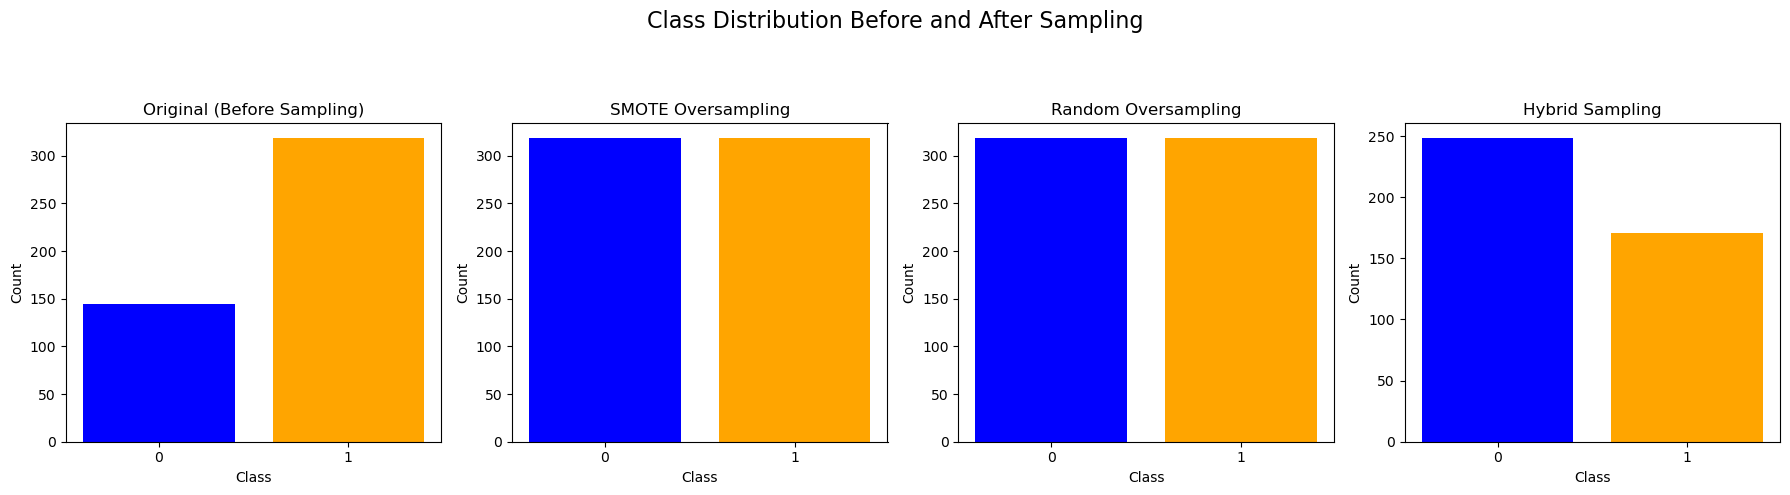

In [20]:
def plot_distribution(y_data, title, ax):
    class_counts = Counter(y_data)
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    ax.bar(classes, counts, color=['blue', 'orange'])
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    ax.set_xticks(classes)

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
fig.suptitle("Class Distribution Before and After Sampling", fontsize=16)

# Plot distributions
datasets = [
    (y_train, "Original (Before Sampling)"),
    (y_train_smote, "SMOTE Oversampling"),
    (y_train_over, "Random Oversampling"),
    (y_train_hybrid, "Hybrid Sampling"),
]

for ax, (y_data, title) in zip(axes.flatten(), datasets):
    plot_distribution(y_data, title, ax)

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

In [21]:
train_sets, configs = modelling.model_config(X_train, y_train, X_train_over, y_train_over, X_train_smote, y_train_smote, X_train_hybrid, y_train_hybrid)

2025-04-04 18:17:02,372 - INFO - Prepared 4 training sets: ['Original Set', 'Oversampled', 'SMOTE', 'Hybrid']
2025-04-04 18:17:02,378 - INFO - Generated 6 model configurations.


In [24]:
# === Model Training Configuration ===
# This loop runs the model with different combinations of:
# - class_weight (True/False)
# - use_stratified_kfold (True/False)
# - use_gridsearch (True/False)
#
# The goal was to try all combinations at once to compare results and pick the best, instead of manually testing one config at a time.
# Flexibility: I can skip the iteration and just pass True/False values directly when I want to test a specific configuration only.

In [7]:
model_results = {}

for train_set_name, (X_train, y_train) in train_sets.items(): 
    print(f"Training on dataset: {train_set_name}")

    for config in configs:
        print(f"Current Configuration: {dict(config)}")
        
        model, model_result = modelling.train_model(
            'randomforest', #or xgboost
            X_train, y_train, X_test, y_test, X_val, y_val,
            class_weight = config["class_weight"], 
            use_stratified_kfold = config["use_stratified_kfold"],
            use_gridsearch = config["use_gridsearch"]
        )

        model_results[model] = model_result

    print()


2025-04-03 17:57:43,281 - INFO - Initializing Randomforest Classifier...


Training on dataset: Original Set
Current Configuration: {'class_weight': False, 'use_stratified_kfold': False, 'use_gridsearch': False}


2025-04-03 17:57:45,544 - INFO - Train Metrics: Accuracy=0.9221, Precision=0.9029, Recall=0.9937, F1 Score=0.9461, ROC AUC=0.9903
2025-04-03 17:57:45,940 - INFO - Validation Metrics: Accuracy=0.7857, Precision=0.7812, Recall=0.9804, F1 Score=0.8696, ROC AUC=0.7773
2025-04-03 17:57:46,234 - INFO - Test Metrics: Accuracy=0.7313, Precision=0.7069, Recall=0.9762, F1 Score=0.8200, ROC AUC=0.8343
2025-04-03 17:57:46,239 - INFO - Initializing Randomforest Classifier...


Current Configuration: {'class_weight': True, 'use_stratified_kfold': False, 'use_gridsearch': False}


2025-04-03 17:57:48,574 - INFO - Train Metrics: Accuracy=0.9177, Precision=0.9294, Recall=0.9528, F1 Score=0.9410, ROC AUC=0.9694
2025-04-03 17:57:49,036 - INFO - Validation Metrics: Accuracy=0.8143, Precision=0.8115, Recall=0.9706, F1 Score=0.8839, ROC AUC=0.7802
2025-04-03 17:57:49,333 - INFO - Test Metrics: Accuracy=0.7761, Precision=0.7455, Recall=0.9762, F1 Score=0.8454, ROC AUC=0.8905
2025-04-03 17:57:49,337 - INFO - Initializing Randomforest Classifier...
2025-04-03 17:57:49,343 - INFO - Performing StratifiedKFold cross-validation...


Current Configuration: {'class_weight': True, 'use_stratified_kfold': True, 'use_gridsearch': False}


2025-04-03 17:57:58,292 - INFO - Cross-Validation ROC AUC Scores: [0.7774784482758621, 0.7524245689655171, 0.7468527640941435, 0.779967159277504, 0.8102678571428571]
2025-04-03 17:57:58,294 - INFO - Mean ROC AUC: 0.7734
2025-04-03 17:57:58,867 - INFO - Train Metrics: Accuracy=0.9004, Precision=0.9072, Recall=0.9528, F1 Score=0.9294, ROC AUC=0.9646
2025-04-03 17:57:59,184 - INFO - Validation Metrics: Accuracy=0.7786, Precision=0.7983, Recall=0.9314, F1 Score=0.8597, ROC AUC=0.7714
2025-04-03 17:57:59,527 - INFO - Test Metrics: Accuracy=0.7761, Precision=0.7647, Recall=0.9286, F1 Score=0.8387, ROC AUC=0.8076
2025-04-03 17:57:59,543 - INFO - Initializing Randomforest Classifier...
2025-04-03 17:57:59,548 - INFO - Performing GridSearchCV for hyperparameter tuning...


Current Configuration: {'class_weight': True, 'use_stratified_kfold': False, 'use_gridsearch': True}
Fitting 5 folds for each of 54 candidates, totalling 270 fits


2025-04-03 18:02:56,185 - INFO - Best Parameters from GridSearchCV: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
2025-04-03 18:02:56,636 - INFO - Train Metrics: Accuracy=0.9762, Precision=0.9812, Recall=0.9843, F1 Score=0.9827, ROC AUC=0.9979
2025-04-03 18:02:56,991 - INFO - Validation Metrics: Accuracy=0.8071, Precision=0.8000, Recall=0.9804, F1 Score=0.8811, ROC AUC=0.7776
2025-04-03 18:02:57,242 - INFO - Test Metrics: Accuracy=0.7612, Precision=0.7321, Recall=0.9762, F1 Score=0.8367, ROC AUC=0.8657
2025-04-03 18:02:57,247 - INFO - Initializing Randomforest Classifier...
2025-04-03 18:02:57,252 - INFO - Performing StratifiedKFold cross-validation...


Current Configuration: {'class_weight': False, 'use_stratified_kfold': True, 'use_gridsearch': False}


2025-04-03 18:03:06,409 - INFO - Cross-Validation ROC AUC Scores: [0.6740301724137931, 0.7085129310344828, 0.7016967706622879, 0.7255062944718118, 0.7622767857142857]
2025-04-03 18:03:06,412 - INFO - Mean ROC AUC: 0.7144
2025-04-03 18:03:06,888 - INFO - Train Metrics: Accuracy=0.9091, Precision=0.8920, Recall=0.9874, F1 Score=0.9373, ROC AUC=0.9776
2025-04-03 18:03:07,168 - INFO - Validation Metrics: Accuracy=0.7786, Precision=0.7840, Recall=0.9608, F1 Score=0.8634, ROC AUC=0.7534
2025-04-03 18:03:07,448 - INFO - Test Metrics: Accuracy=0.7313, Precision=0.7143, Recall=0.9524, F1 Score=0.8163, ROC AUC=0.8229
2025-04-03 18:03:07,460 - INFO - Initializing Randomforest Classifier...
2025-04-03 18:03:07,464 - INFO - Performing GridSearchCV for hyperparameter tuning...


Current Configuration: {'class_weight': False, 'use_stratified_kfold': False, 'use_gridsearch': True}
Fitting 5 folds for each of 54 candidates, totalling 270 fits


2025-04-03 18:07:45,209 - INFO - Best Parameters from GridSearchCV: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 300}
2025-04-03 18:07:45,979 - INFO - Train Metrics: Accuracy=0.9026, Precision=0.8824, Recall=0.9906, F1 Score=0.9333, ROC AUC=0.9805
2025-04-03 18:07:46,654 - INFO - Validation Metrics: Accuracy=0.7857, Precision=0.7812, Recall=0.9804, F1 Score=0.8696, ROC AUC=0.7781
2025-04-03 18:07:47,102 - INFO - Test Metrics: Accuracy=0.7463, Precision=0.7193, Recall=0.9762, F1 Score=0.8283, ROC AUC=0.8448
2025-04-03 18:07:47,115 - INFO - Initializing Randomforest Classifier...



Training on dataset: Oversampled
Current Configuration: {'class_weight': False, 'use_stratified_kfold': False, 'use_gridsearch': False}


2025-04-03 18:07:50,932 - INFO - Train Metrics: Accuracy=0.9748, Precision=0.9660, Recall=0.9843, F1 Score=0.9751, ROC AUC=0.9965
2025-04-03 18:07:51,461 - INFO - Validation Metrics: Accuracy=0.7929, Precision=0.8067, Recall=0.9412, F1 Score=0.8688, ROC AUC=0.7869
2025-04-03 18:07:51,950 - INFO - Test Metrics: Accuracy=0.7463, Precision=0.7358, Recall=0.9286, F1 Score=0.8211, ROC AUC=0.8552
2025-04-03 18:07:51,955 - INFO - Initializing Randomforest Classifier...


Current Configuration: {'class_weight': True, 'use_stratified_kfold': False, 'use_gridsearch': False}


2025-04-03 18:07:54,655 - INFO - Train Metrics: Accuracy=0.9277, Precision=0.9146, Recall=0.9434, F1 Score=0.9288, ROC AUC=0.9788
2025-04-03 18:07:55,039 - INFO - Validation Metrics: Accuracy=0.7857, Precision=0.8051, Recall=0.9314, F1 Score=0.8636, ROC AUC=0.7510
2025-04-03 18:07:55,342 - INFO - Test Metrics: Accuracy=0.7612, Precision=0.7708, Recall=0.8810, F1 Score=0.8222, ROC AUC=0.8571
2025-04-03 18:07:55,346 - INFO - Initializing Randomforest Classifier...
2025-04-03 18:07:55,351 - INFO - Performing StratifiedKFold cross-validation...


Current Configuration: {'class_weight': True, 'use_stratified_kfold': True, 'use_gridsearch': False}


2025-04-03 18:08:06,733 - INFO - Cross-Validation ROC AUC Scores: [0.828125, 0.9372519841269842, 0.8426339285714286, 0.8577628968253969, 0.8501984126984126]
2025-04-03 18:08:06,735 - INFO - Mean ROC AUC: 0.8632
2025-04-03 18:08:07,367 - INFO - Train Metrics: Accuracy=0.9230, Precision=0.9113, Recall=0.9371, F1 Score=0.9240, ROC AUC=0.9757
2025-04-03 18:08:07,728 - INFO - Validation Metrics: Accuracy=0.7786, Precision=0.8142, Recall=0.9020, F1 Score=0.8558, ROC AUC=0.7407
2025-04-03 18:08:08,027 - INFO - Test Metrics: Accuracy=0.7463, Precision=0.7551, Recall=0.8810, F1 Score=0.8132, ROC AUC=0.8257
2025-04-03 18:08:08,031 - INFO - Initializing Randomforest Classifier...
2025-04-03 18:08:08,037 - INFO - Performing GridSearchCV for hyperparameter tuning...


Current Configuration: {'class_weight': True, 'use_stratified_kfold': False, 'use_gridsearch': True}
Fitting 5 folds for each of 54 candidates, totalling 270 fits


2025-04-03 18:13:24,550 - INFO - Best Parameters from GridSearchCV: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
2025-04-03 18:13:25,935 - INFO - Train Metrics: Accuracy=0.9796, Precision=0.9721, Recall=0.9874, F1 Score=0.9797, ROC AUC=0.9982
2025-04-03 18:13:26,722 - INFO - Validation Metrics: Accuracy=0.8214, Precision=0.8182, Recall=0.9706, F1 Score=0.8879, ROC AUC=0.7835
2025-04-03 18:13:27,240 - INFO - Test Metrics: Accuracy=0.7463, Precision=0.7358, Recall=0.9286, F1 Score=0.8211, ROC AUC=0.8943
2025-04-03 18:13:27,247 - INFO - Initializing Randomforest Classifier...
2025-04-03 18:13:27,259 - INFO - Performing StratifiedKFold cross-validation...


Current Configuration: {'class_weight': False, 'use_stratified_kfold': True, 'use_gridsearch': False}


2025-04-03 18:13:43,384 - INFO - Cross-Validation ROC AUC Scores: [0.8828125, 0.9605654761904762, 0.9368799603174602, 0.8973214285714286, 0.8740079365079365]
2025-04-03 18:13:43,387 - INFO - Mean ROC AUC: 0.9103
2025-04-03 18:13:43,942 - INFO - Train Metrics: Accuracy=0.9497, Precision=0.9469, Recall=0.9528, F1 Score=0.9498, ROC AUC=0.9925
2025-04-03 18:13:44,364 - INFO - Validation Metrics: Accuracy=0.7857, Precision=0.8051, Recall=0.9314, F1 Score=0.8636, ROC AUC=0.7469
2025-04-03 18:13:44,590 - INFO - Test Metrics: Accuracy=0.7463, Precision=0.7358, Recall=0.9286, F1 Score=0.8211, ROC AUC=0.8543
2025-04-03 18:13:44,594 - INFO - Initializing Randomforest Classifier...
2025-04-03 18:13:44,598 - INFO - Performing GridSearchCV for hyperparameter tuning...


Current Configuration: {'class_weight': False, 'use_stratified_kfold': False, 'use_gridsearch': True}
Fitting 5 folds for each of 54 candidates, totalling 270 fits


2025-04-03 18:20:37,340 - INFO - Best Parameters from GridSearchCV: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
2025-04-03 18:20:38,314 - INFO - Train Metrics: Accuracy=0.9796, Precision=0.9721, Recall=0.9874, F1 Score=0.9797, ROC AUC=0.9982
2025-04-03 18:20:38,905 - INFO - Validation Metrics: Accuracy=0.8214, Precision=0.8182, Recall=0.9706, F1 Score=0.8879, ROC AUC=0.7835
2025-04-03 18:20:39,241 - INFO - Test Metrics: Accuracy=0.7463, Precision=0.7358, Recall=0.9286, F1 Score=0.8211, ROC AUC=0.8943
2025-04-03 18:20:39,247 - INFO - Initializing Randomforest Classifier...



Training on dataset: SMOTE
Current Configuration: {'class_weight': False, 'use_stratified_kfold': False, 'use_gridsearch': False}


2025-04-03 18:20:42,023 - INFO - Train Metrics: Accuracy=0.9670, Precision=0.9714, Recall=0.9623, F1 Score=0.9668, ROC AUC=0.9962
2025-04-03 18:20:42,430 - INFO - Validation Metrics: Accuracy=0.8000, Precision=0.8083, Recall=0.9510, F1 Score=0.8739, ROC AUC=0.7717
2025-04-03 18:20:42,771 - INFO - Test Metrics: Accuracy=0.8209, Precision=0.8000, Recall=0.9524, F1 Score=0.8696, ROC AUC=0.8667
2025-04-03 18:20:42,778 - INFO - Initializing Randomforest Classifier...


Current Configuration: {'class_weight': True, 'use_stratified_kfold': False, 'use_gridsearch': False}


2025-04-03 18:20:45,841 - INFO - Train Metrics: Accuracy=0.9025, Precision=0.8787, Recall=0.9340, F1 Score=0.9055, ROC AUC=0.9734
2025-04-03 18:20:46,239 - INFO - Validation Metrics: Accuracy=0.7929, Precision=0.8120, Recall=0.9314, F1 Score=0.8676, ROC AUC=0.7572
2025-04-03 18:20:46,535 - INFO - Test Metrics: Accuracy=0.7910, Precision=0.7800, Recall=0.9286, F1 Score=0.8478, ROC AUC=0.8629
2025-04-03 18:20:46,542 - INFO - Initializing Randomforest Classifier...
2025-04-03 18:20:46,548 - INFO - Performing StratifiedKFold cross-validation...


Current Configuration: {'class_weight': True, 'use_stratified_kfold': True, 'use_gridsearch': False}


2025-04-03 18:20:57,225 - INFO - Cross-Validation ROC AUC Scores: [0.8359375, 0.9135664682539683, 0.8428819444444444, 0.8260168650793652, 0.8504464285714286]
2025-04-03 18:20:57,226 - INFO - Mean ROC AUC: 0.8538
2025-04-03 18:20:57,779 - INFO - Train Metrics: Accuracy=0.9119, Precision=0.8970, Recall=0.9308, F1 Score=0.9136, ROC AUC=0.9710
2025-04-03 18:20:58,119 - INFO - Validation Metrics: Accuracy=0.7857, Precision=0.8158, Recall=0.9118, F1 Score=0.8611, ROC AUC=0.7642
2025-04-03 18:20:58,453 - INFO - Test Metrics: Accuracy=0.8209, Precision=0.8125, Recall=0.9286, F1 Score=0.8667, ROC AUC=0.8362
2025-04-03 18:20:58,468 - INFO - Initializing Randomforest Classifier...
2025-04-03 18:20:58,481 - INFO - Performing GridSearchCV for hyperparameter tuning...


Current Configuration: {'class_weight': True, 'use_stratified_kfold': False, 'use_gridsearch': True}
Fitting 5 folds for each of 54 candidates, totalling 270 fits


2025-04-03 18:26:14,933 - INFO - Best Parameters from GridSearchCV: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
2025-04-03 18:26:15,672 - INFO - Train Metrics: Accuracy=0.9796, Precision=0.9872, Recall=0.9717, F1 Score=0.9794, ROC AUC=0.9985
2025-04-03 18:26:16,037 - INFO - Validation Metrics: Accuracy=0.7786, Precision=0.8034, Recall=0.9216, F1 Score=0.8584, ROC AUC=0.7712
2025-04-03 18:26:16,281 - INFO - Test Metrics: Accuracy=0.8209, Precision=0.8000, Recall=0.9524, F1 Score=0.8696, ROC AUC=0.8943
2025-04-03 18:26:16,289 - INFO - Initializing Randomforest Classifier...
2025-04-03 18:26:16,293 - INFO - Performing StratifiedKFold cross-validation...


Current Configuration: {'class_weight': False, 'use_stratified_kfold': True, 'use_gridsearch': False}


2025-04-03 18:26:25,878 - INFO - Cross-Validation ROC AUC Scores: [0.84375, 0.9135664682539683, 0.8585069444444444, 0.8735119047619048, 0.8661954365079365]
2025-04-03 18:26:25,880 - INFO - Mean ROC AUC: 0.8711
2025-04-03 18:26:26,389 - INFO - Train Metrics: Accuracy=0.9481, Precision=0.9582, Recall=0.9371, F1 Score=0.9475, ROC AUC=0.9927
2025-04-03 18:26:26,766 - INFO - Validation Metrics: Accuracy=0.7929, Precision=0.8120, Recall=0.9314, F1 Score=0.8676, ROC AUC=0.7908
2025-04-03 18:26:27,003 - INFO - Test Metrics: Accuracy=0.7015, Precision=0.7391, Recall=0.8095, F1 Score=0.7727, ROC AUC=0.8181
2025-04-03 18:26:27,010 - INFO - Initializing Randomforest Classifier...
2025-04-03 18:26:27,013 - INFO - Performing GridSearchCV for hyperparameter tuning...


Current Configuration: {'class_weight': False, 'use_stratified_kfold': False, 'use_gridsearch': True}
Fitting 5 folds for each of 54 candidates, totalling 270 fits


2025-04-03 18:31:30,378 - INFO - Best Parameters from GridSearchCV: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
2025-04-03 18:31:30,960 - INFO - Train Metrics: Accuracy=0.9796, Precision=0.9872, Recall=0.9717, F1 Score=0.9794, ROC AUC=0.9985
2025-04-03 18:31:31,238 - INFO - Validation Metrics: Accuracy=0.7786, Precision=0.8034, Recall=0.9216, F1 Score=0.8584, ROC AUC=0.7712
2025-04-03 18:31:31,434 - INFO - Test Metrics: Accuracy=0.8209, Precision=0.8000, Recall=0.9524, F1 Score=0.8696, ROC AUC=0.8943
2025-04-03 18:31:31,440 - INFO - Initializing Randomforest Classifier...



Training on dataset: Hybrid
Current Configuration: {'class_weight': False, 'use_stratified_kfold': False, 'use_gridsearch': False}


2025-04-03 18:31:33,396 - INFO - Train Metrics: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1 Score=1.0000, ROC AUC=1.0000
2025-04-03 18:31:33,711 - INFO - Validation Metrics: Accuracy=0.7286, Precision=0.8333, Recall=0.7843, F1 Score=0.8081, ROC AUC=0.7882
2025-04-03 18:31:33,934 - INFO - Test Metrics: Accuracy=0.7463, Precision=0.8378, Recall=0.7381, F1 Score=0.7848, ROC AUC=0.8314
2025-04-03 18:31:33,940 - INFO - Initializing Randomforest Classifier...


Current Configuration: {'class_weight': True, 'use_stratified_kfold': False, 'use_gridsearch': False}


2025-04-03 18:31:36,016 - INFO - Train Metrics: Accuracy=0.9901, Precision=0.9753, Recall=1.0000, F1 Score=0.9875, ROC AUC=0.9992
2025-04-03 18:31:36,284 - INFO - Validation Metrics: Accuracy=0.7714, Precision=0.8500, Recall=0.8333, F1 Score=0.8416, ROC AUC=0.8114
2025-04-03 18:31:36,546 - INFO - Test Metrics: Accuracy=0.8060, Precision=0.8537, Recall=0.8333, F1 Score=0.8434, ROC AUC=0.8324
2025-04-03 18:31:36,550 - INFO - Initializing Randomforest Classifier...
2025-04-03 18:31:36,555 - INFO - Performing StratifiedKFold cross-validation...


Current Configuration: {'class_weight': True, 'use_stratified_kfold': True, 'use_gridsearch': False}


2025-04-03 18:31:45,495 - INFO - Cross-Validation ROC AUC Scores: [0.8716129032258064, 0.9123086734693878, 0.9591836734693878, 0.9741709183673469, 0.9795918367346939]
2025-04-03 18:31:45,496 - INFO - Mean ROC AUC: 0.9394
2025-04-03 18:31:45,873 - INFO - Train Metrics: Accuracy=0.9827, Precision=0.9576, Recall=1.0000, F1 Score=0.9783, ROC AUC=0.9996
2025-04-03 18:31:46,318 - INFO - Validation Metrics: Accuracy=0.7929, Precision=0.8544, Recall=0.8627, F1 Score=0.8585, ROC AUC=0.8132
2025-04-03 18:31:46,684 - INFO - Test Metrics: Accuracy=0.8060, Precision=0.8537, Recall=0.8333, F1 Score=0.8434, ROC AUC=0.8467
2025-04-03 18:31:46,688 - INFO - Initializing Randomforest Classifier...
2025-04-03 18:31:46,692 - INFO - Performing GridSearchCV for hyperparameter tuning...


Current Configuration: {'class_weight': True, 'use_stratified_kfold': False, 'use_gridsearch': True}
Fitting 5 folds for each of 54 candidates, totalling 270 fits


2025-04-03 18:36:33,020 - INFO - Best Parameters from GridSearchCV: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
2025-04-03 18:36:33,692 - INFO - Train Metrics: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1 Score=1.0000, ROC AUC=1.0000
2025-04-03 18:36:34,172 - INFO - Validation Metrics: Accuracy=0.7643, Precision=0.8557, Recall=0.8137, F1 Score=0.8342, ROC AUC=0.8256
2025-04-03 18:36:34,532 - INFO - Test Metrics: Accuracy=0.7761, Precision=0.8462, Recall=0.7857, F1 Score=0.8148, ROC AUC=0.8267
2025-04-03 18:36:34,540 - INFO - Initializing Randomforest Classifier...
2025-04-03 18:36:34,544 - INFO - Performing StratifiedKFold cross-validation...


Current Configuration: {'class_weight': False, 'use_stratified_kfold': True, 'use_gridsearch': False}


2025-04-03 18:36:43,828 - INFO - Cross-Validation ROC AUC Scores: [0.8993548387096774, 0.9225127551020409, 1.0, 0.9429209183673469, 0.9736668861092824]
2025-04-03 18:36:43,829 - INFO - Mean ROC AUC: 0.9477
2025-04-03 18:36:44,406 - INFO - Train Metrics: Accuracy=0.9950, Precision=0.9937, Recall=0.9937, F1 Score=0.9937, ROC AUC=0.9999
2025-04-03 18:36:44,708 - INFO - Validation Metrics: Accuracy=0.7286, Precision=0.8333, Recall=0.7843, F1 Score=0.8081, ROC AUC=0.7970
2025-04-03 18:36:44,970 - INFO - Test Metrics: Accuracy=0.7463, Precision=0.8205, Recall=0.7619, F1 Score=0.7901, ROC AUC=0.8067
2025-04-03 18:36:44,980 - INFO - Initializing Randomforest Classifier...
2025-04-03 18:36:44,984 - INFO - Performing GridSearchCV for hyperparameter tuning...


Current Configuration: {'class_weight': False, 'use_stratified_kfold': False, 'use_gridsearch': True}
Fitting 5 folds for each of 54 candidates, totalling 270 fits


2025-04-03 18:41:42,333 - INFO - Best Parameters from GridSearchCV: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
2025-04-03 18:41:42,982 - INFO - Train Metrics: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1 Score=1.0000, ROC AUC=1.0000
2025-04-03 18:41:43,411 - INFO - Validation Metrics: Accuracy=0.7571, Precision=0.8542, Recall=0.8039, F1 Score=0.8283, ROC AUC=0.8003
2025-04-03 18:41:43,765 - INFO - Test Metrics: Accuracy=0.7463, Precision=0.8378, Recall=0.7381, F1 Score=0.7848, ROC AUC=0.8390


2025-04-03 18:41:44,425 - INFO - Best Model: RandomForestClassifier(class_weight={0: 1.0, 1: 1.0}, max_depth=5,
                       n_estimators=300, n_jobs=-1, random_state=42), Best ROC-AUC Score: 0.8942857142857144
2025-04-03 18:41:44,454 - INFO - Best Model: RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=300,
                       n_jobs=-1, random_state=42)
2025-04-03 18:41:44,456 - INFO - Best ROC-AUC Score: 0.8943


+------------------+--------------------+--------------------+--------------------+
|                  | Train              | Validation         | Test               |
+==================+====================+====================+====================+
| confusion_matrix | (309, 9, 4, 314)   | (16, 22, 3, 99)    | (11, 14, 3, 39)    |
+------------------+--------------------+--------------------+--------------------+
| accuracy         | 0.9795597484276729 | 0.8214285714285714 | 0.746268656716418  |
+------------------+--------------------+--------------------+--------------------+
| precision        | 0.9721362229102167 | 0.8181818181818182 | 0.7358490566037735 |
+------------------+--------------------+--------------------+--------------------+
| recall           | 0.9874213836477987 | 0.9705882352941176 | 0.9285714285714286 |
+------------------+--------------------+--------------------+--------------------+
| f1_score         | 0.9797191887675507 | 0.8878923766816144 | 0.82105263157

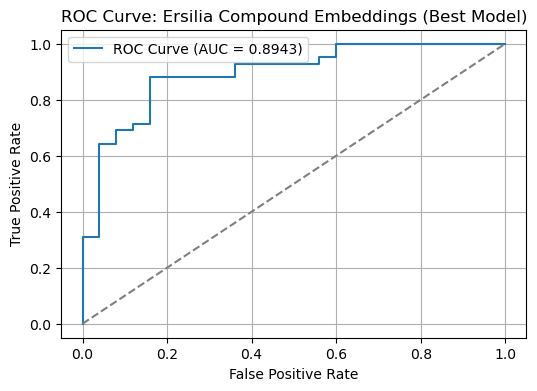

2025-04-03 18:41:47,150 - INFO - ROC Curve saved at ../data/figures/ROC Curve - Ersilia Compound Embeddings (Best Model).png


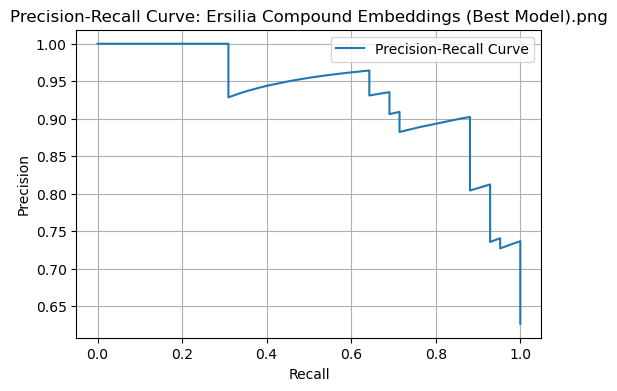

2025-04-03 18:41:48,299 - INFO - Precision-Recall Curve saved at ../data/figures/Precision-Recall Curve - Ersilia Compound Embeddings (Best Model).png
2025-04-03 18:41:48,314 - INFO - Specificity: 0.4400, Negative Predictive Value: 0.7857


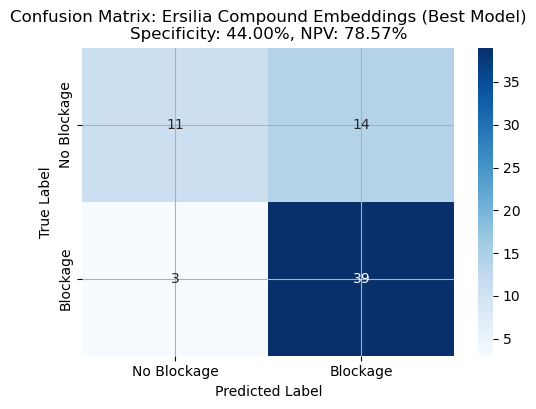

2025-04-03 18:41:49,111 - INFO - Confusion Matrix saved at ../data/figures/Confusion Matrix - Ersilia Compound Embeddings (Best Model).png


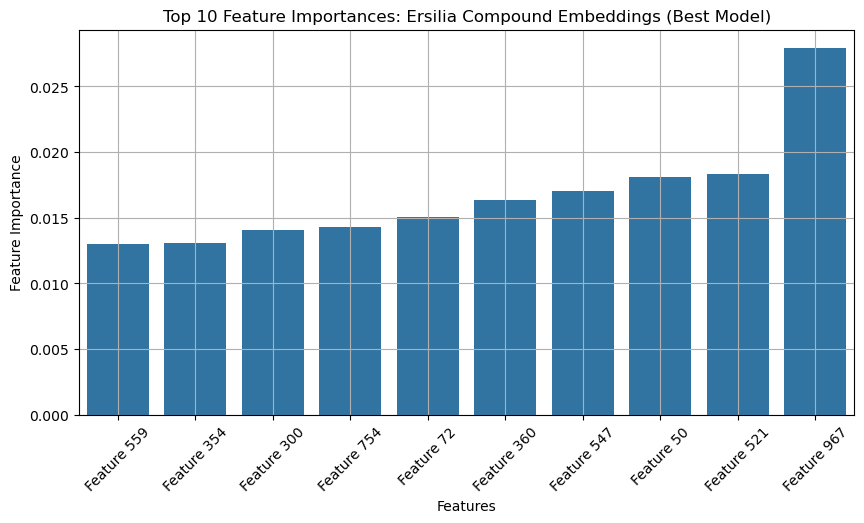

2025-04-03 18:41:51,028 - INFO - Top 10 Feature Importances saved at ../data/figures/Top 10 Feature Importances - Ersilia Compound Embeddings (Best Model).png
2025-04-03 18:41:51,034 - INFO - Top 10 Feature Importances: [('Feature 559', 0.013027186689756666), ('Feature 354', 0.01310527868119541), ('Feature 300', 0.014059199118880726), ('Feature 754', 0.014285134063582849), ('Feature 72', 0.015075106039379168), ('Feature 360', 0.01636887055526224), ('Feature 547', 0.01701792633535638), ('Feature 50', 0.018094107034845108), ('Feature 521', 0.01832974670824731), ('Feature 967', 0.02792107882915057)]


In [8]:
# Get Best Result by Highest ROC-AUC and visualize
model, model_result = modelling.evaluate_model(model_results)

graph_title = "Ersilia Compound Embeddings (Best Model)"
modelling.visualize_model(model, model_result, graph_title , y_test)

In [9]:
# with open("../models/best_eos2gw4_model2.pkl", "wb") as f:
#     pkl.dump(model, f)
# print("Model Saved")